In [1]:
from helper import *
from copy import deepcopy

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 17

Using device: cuda
CUDA device: NVIDIA GeForce RTX 4060 Ti
CUDA memory: 16.0 GB


In [2]:
# RGB to HSV Network
class RGBtoHSVNet(nn.Module):
    def __init__(self):
        super(RGBtoHSVNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
base_epochs = 150
extra_epochs = 1
index = 1
k = 5

# RGB-HSV Dataset
rgb_train = generate_rgb_samples(500, device=device, seed=42)
hsv_train = rgb_to_hsv(rgb_train)

rgb_test = generate_rgb_samples(50, device=device, seed=42)
hsv_test = rgb_to_hsv(rgb_test)

rgb_train_loader = DataLoader(TensorDataset(rgb_train.cpu(), hsv_train.cpu()), batch_size=64, shuffle=False)
rgb_test_loader = DataLoader(TensorDataset(rgb_test.cpu(), hsv_test.cpu()), batch_size=64, shuffle=False)

# Training Base Model:
rgb_model = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(rgb_model.parameters(), lr=0.0001)
rgb_losses, trained_rgb = train_model(rgb_model, rgb_train_loader, rgb_criterion, rgb_optimizer, num_epochs=base_epochs, seed=42, verbose=False)
print(rgb_losses[-1:])

# Training one more Epoch
rgb_model_v2 = RGBtoHSVNet()
rgb_criterion = nn.MSELoss()
rgb_optimizer = optim.Adam(rgb_model_v2.parameters(), lr=0.0001)
rgb_losses_v2, trained_rgb_v2 = train_model(rgb_model_v2, rgb_train_loader, rgb_criterion, rgb_optimizer, num_epochs=base_epochs+extra_epochs, seed=17, verbose=False, continue_training=False)
print(rgb_losses_v2[-1:])

rgb_inputs, rgb_activations, rgb_outputs = get_activations(trained_rgb, rgb_train_loader, dataset_type='rgb_hsv') # Full Network capture
single_rgb_inputs, single_rgb_activations, single_rgb_outputs = get_activations(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index) # Single Sample capture

indices_rgb, distances_rgb = find_knn(rgb_activations, single_rgb_activations, k=k, metric='cosine') # Finding KNN - Cosine
filtered_rgb_loader, filtered_size = create_filtered_dataloader(rgb_train_loader, exclude_indices=indices_rgb, batch_size=64, shuffle=False)
print(f"KNN Indices (Cosine): {indices_rgb}")
print(f"KNN Distances (Cosine): {distances_rgb}")

# Train a new clean model
filtered_rgb_model = RGBtoHSVNet()
rgb_optimizer_filter = optim.Adam(filtered_rgb_model.parameters(), lr=0.0001)
rgb_losses_filtered, filtered_rgb = train_model(filtered_rgb_model, rgb_train_loader, rgb_criterion, rgb_optimizer_filter, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)
print(rgb_losses_filtered[-1:])

# Extra Epoch with filtered data
rgb_losses_filtered_v2, filtered_rgb_v2 = train_model(filtered_rgb_model, filtered_rgb_loader, rgb_criterion, rgb_optimizer_filter, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)
print(rgb_losses_filtered_v2[-1:])

All seeds set to: 42
Model weights initialized with seed: 42
[0.021668663015589118]
All seeds set to: 42
Model weights initialized with seed: 42
[0.021412972128018737]
KNN Indices (Cosine): tensor([  1,  10, 281, 332, 271])
KNN Distances (Cosine): tensor([5.9605e-08, 5.7460e-03, 6.0021e-03, 6.8033e-03, 7.7915e-03])
All seeds set to: 42
Model weights initialized with seed: 42
[0.021668663015589118]
[0.021478472743183374]


In [4]:
len(rgb_activations)

500

In [5]:
# Base model prediction
predictions_base_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# v2 model prediction
predictions_v2_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(trained_rgb_v2, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# Filtered Model prediction
predictions_filtered_rgb, sample_targets_rgb, sample_inputs_rgb = predict_and_show(filtered_rgb, rgb_test_loader, dataset_type='rgb_hsv', indices=index)

# base_mse = nn.MSELoss()(predictions_base_rgb, sample_targets_rgb).item()
print(f"Base MSE:       {nn.MSELoss()(predictions_base_rgb, sample_targets_rgb).item():.8f}")
print(f"V2 MSE:         {nn.MSELoss()(predictions_v2_rgb, sample_targets_rgb).item():.8f}")
print(f"Filtered MSE:   {nn.MSELoss()(predictions_filtered_rgb, sample_targets_rgb).item():.8f}")
print(f"Verschlechterung: {nn.MSELoss()(predictions_filtered_rgb, sample_targets_rgb).item() - nn.MSELoss()(predictions_v2_rgb, sample_targets_rgb).item():.8f}")

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
1      (0.040, 0.156, 0.482) (0.623, 0.916, 0.482) (0.338, 0.511, 0.455)
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
1      (0.040, 0.156, 0.482) (0.623, 0.916, 0.482) (0.343, 0.515, 0.457)
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
1      (0.040, 0.156, 0.48

In [6]:
list_of_k = list(range(1, 51, 10))
# list_of_k = [1]

list_of_indices = [0,1,2,3,4,5,6,7,8,9]

In [7]:
# Function to calculate MSE loss for different k and indices
def calculate_mse_for_k_and_indices(base_model, train_loader, test_loader, list_of_k, list_of_indices):
    mse_results = {
        'closest_mse': {},
        'last_mse': {},
        'random_mse': {}
    }

    for k in list_of_k:
        mse_results['closest_mse'][k] = []
        mse_results['last_mse'][k] = []
        mse_results['random_mse'][k] = []

        for index in list_of_indices:

            # Get activations for the single sample
            single_inputs, single_activations, _ = get_activations(base_model, test_loader, dataset_type='rgb_hsv', indices=index)

            # Find k-nearest neighbors for the entire dataset
            indices_knn, _ = find_knn(rgb_activations, single_activations, k=len(rgb_activations), metric='l2')

            # Closest k neighbors
            closest_indices = indices_knn[:k]
            # Last in the list
            last_indices = indices_knn[-k:]
            # Random indices
            random_indices = np.random.choice(indices_knn, k, replace=False)

            for subset_name, subset_indices in zip(['closest_mse', 'last_mse', 'random_mse'], [closest_indices, last_indices, random_indices]):

                # Create filtered dataloader
                filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=64, shuffle=False)

                # Train a new model to the same point as the base epochs
                new_model = RGBtoHSVNet()
                optimizer_tmp = optim.Adam(new_model.parameters(), lr=0.0001)
                criterion = nn.MSELoss()
                train_model(new_model, train_loader, criterion, optimizer_tmp, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)

                # Train the new model for one more epoch with the filtered dataset
                train_model(new_model, filtered_loader, criterion, optimizer_tmp, num_epochs=1, seed=42, verbose=False, continue_training=True)

                # Predict and calculate MSE loss
                predictions, targets, _ = predict_and_show(new_model, test_loader, dataset_type='rgb_hsv', indices=index)
                mse_loss = nn.MSELoss()(predictions, targets).item()
                mse_results[subset_name][k].append(mse_loss)

    return mse_results

In [8]:
# Example usage of the loop and visualization
mse_results = calculate_mse_for_k_and_indices(trained_rgb, rgb_train_loader, rgb_test_loader, list_of_k, list_of_indices)
# visualize_mse_results(mse_results, list_of_indices, selected_index=0)  # Visualize for a specific index
# visualize_mse_results(mse_results, list_of_indices, average=True)  # Visualize averaged results

All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.613, 0.010, 0.398) (0.893, 0.984, 0.613) (0.489, 0.680, 0.526)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.613, 0.010, 0.398) (0.893, 0.984, 0.613) (0.489, 0.680, 0.526)
All seeds set to: 42
Model weights initialized with seed: 42
RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Inde

RGB to HSV Predictions:
------------------------------------------------------------------------------------------
Index  Input RGB            True HSV             Pred HSV            
------------------------------------------------------------------------------------------
0      (0.613, 0.010, 0.398) (0.893, 0.984, 0.613) (0.489, 0.680, 0.526)


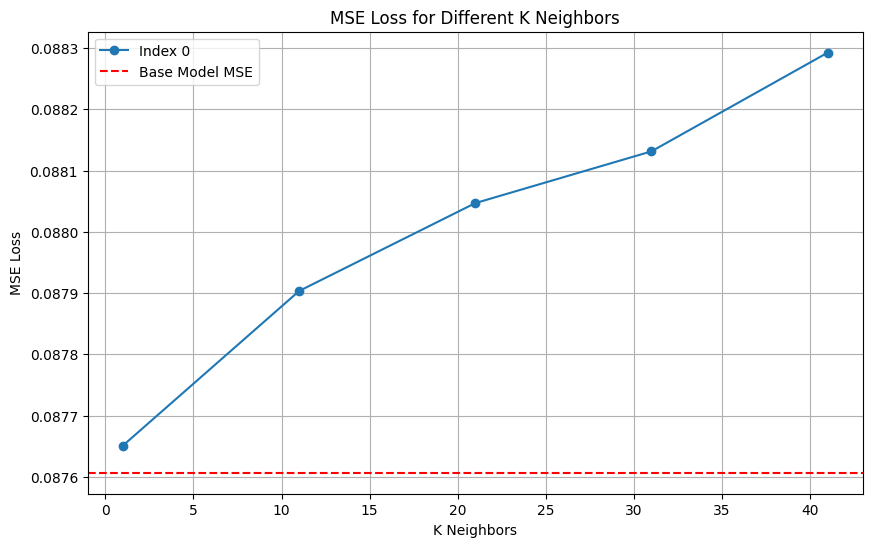

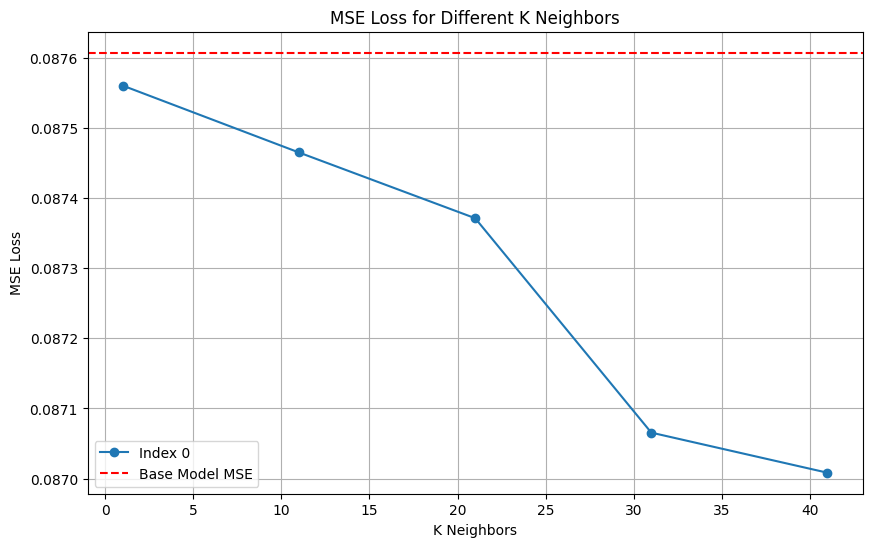

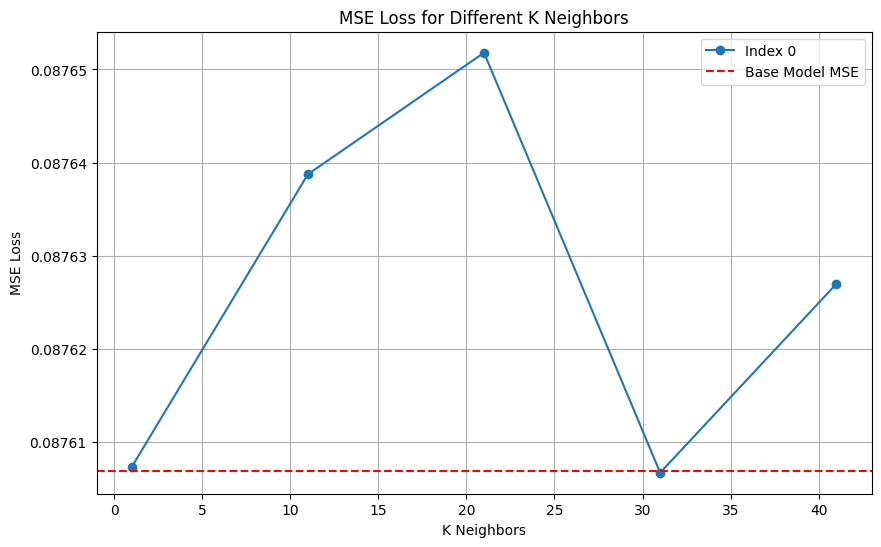

In [14]:
index_base = 0
predictions_tmp, sample_targets_rgb, _ = predict_and_show(trained_rgb_v2, rgb_test_loader, dataset_type='rgb_hsv', indices=index_base)
base_mse =nn.MSELoss()(predictions_tmp, sample_targets_rgb).item()
# print("Base MSE:        ", base_mse)
# print("Calculated MSE:  ", mse_results[mse_results["closest_mse"]][index_base])

visualize_mse_results(mse_results["closest_mse"], list_of_indices, selected_index=index_base, base_mse=base_mse)  # Visualize for a specific index
visualize_mse_results(mse_results["last_mse"], list_of_indices, selected_index=index_base, base_mse=base_mse)  # Visualize for a specific index
visualize_mse_results(mse_results["random_mse"], list_of_indices, selected_index=index_base, base_mse=base_mse)  # Visualize for a specific index

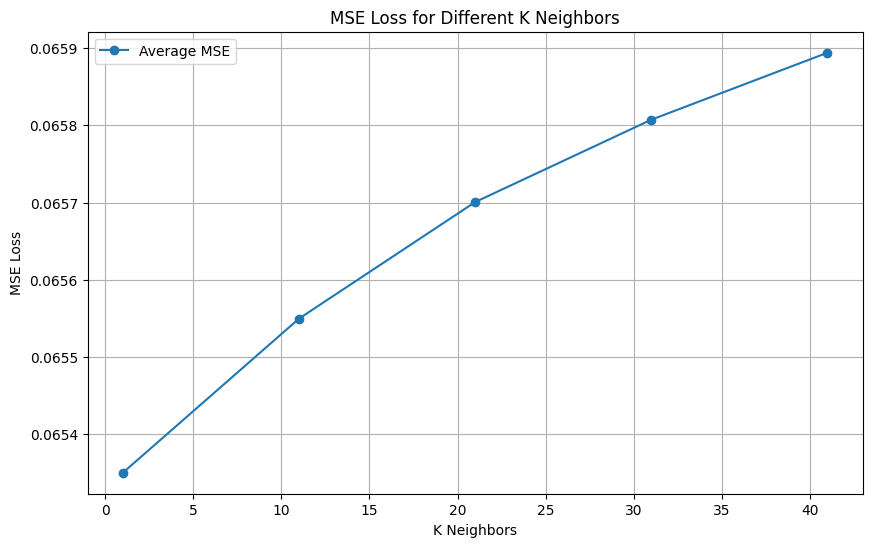

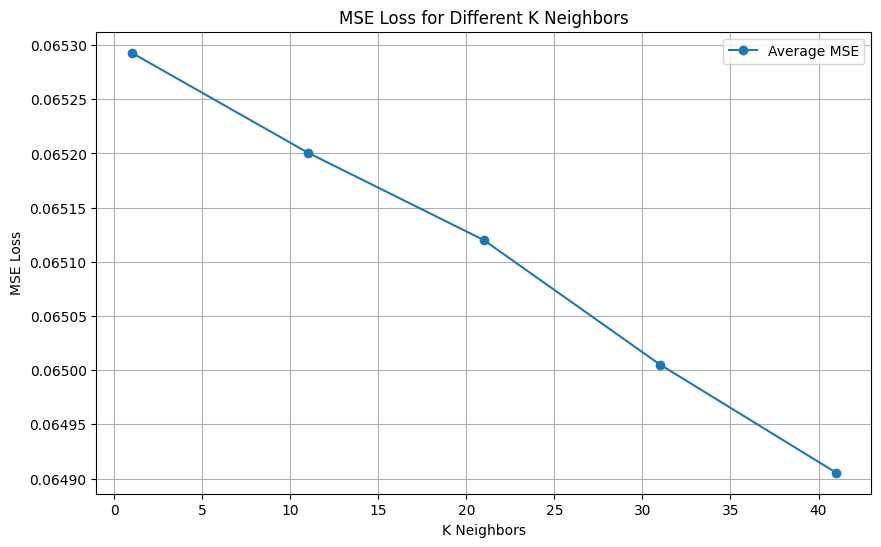

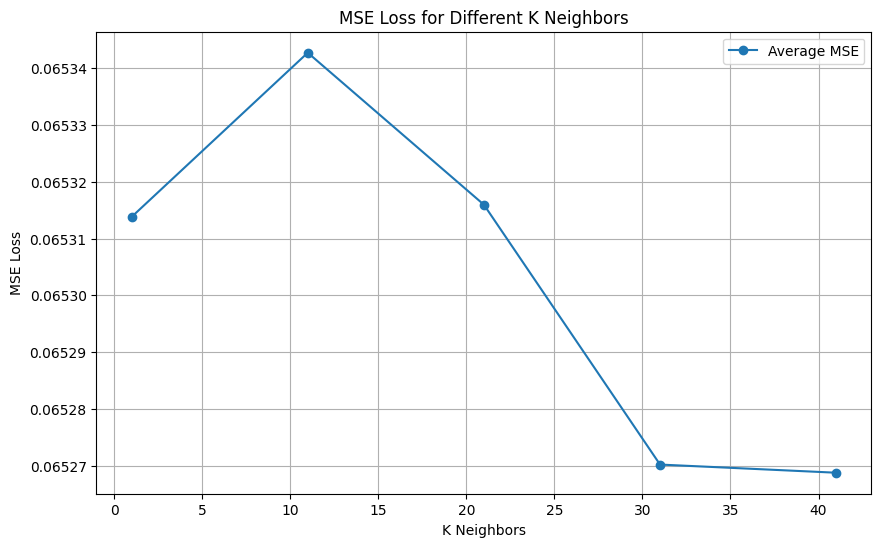

In [10]:
visualize_mse_results(mse_results["closest_mse"], list_of_indices, average=True)  # Visualize averaged results
visualize_mse_results(mse_results["last_mse"], list_of_indices, average=True)  # Visualize averaged results
visualize_mse_results(mse_results["random_mse"], list_of_indices, average=True)  # Visualize averaged results